In [1]:
### Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pymc3 as pm
import corner

import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)
matplotlib.rcParams.update({'font.size': 14})

import logging
logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

In [2]:
### Files and folders
data_dir = "data/"
mass_distr_file = data_dir+"NS_masses_2.dat"
plot_dir = "plots/"

In [3]:
### Plot NS mass distribution
# From http://xtreme.as.arizona.edu/NeutronStars/ + others
colnames = ["mass", "minusErr", "plusErr", "category", "rank", "name"]
mass_distr = pd.read_csv(mass_distr_file, names=colnames, sep="\s+")

In [4]:
### Data formatting
categories = list(mass_distr.category)
bounds = []
for cat in np.unique(categories):
    bounds.append(categories.index(cat))
    
masses = list(mass_distr.mass)
loErr = list(mass_distr.minusErr)
hiErr = list(mass_distr.plusErr)
space = 3
for i,bound in enumerate(bounds[1:]):
    for _ in range(space):
        masses.insert(i*space+bound, np.nan)
        loErr.insert(i*space+bound, np.nan)
        hiErr.insert(i*space+bound, np.nan)
ticks = [i*space+bound+1 for i,bound in enumerate(bounds[1:])]
bounds = ticks+[len(masses)]
labels = [bounds[i] - (bounds[i]-(bounds[i-1] if i!=0 else 0))/2 for i in range(len(bounds))]

In [5]:
# Pulsar category names
cats = list(np.unique(categories))
cat_names = ["Double neutron stars", "Recycled pulsars", "Bursters", "Slow pulsars"]

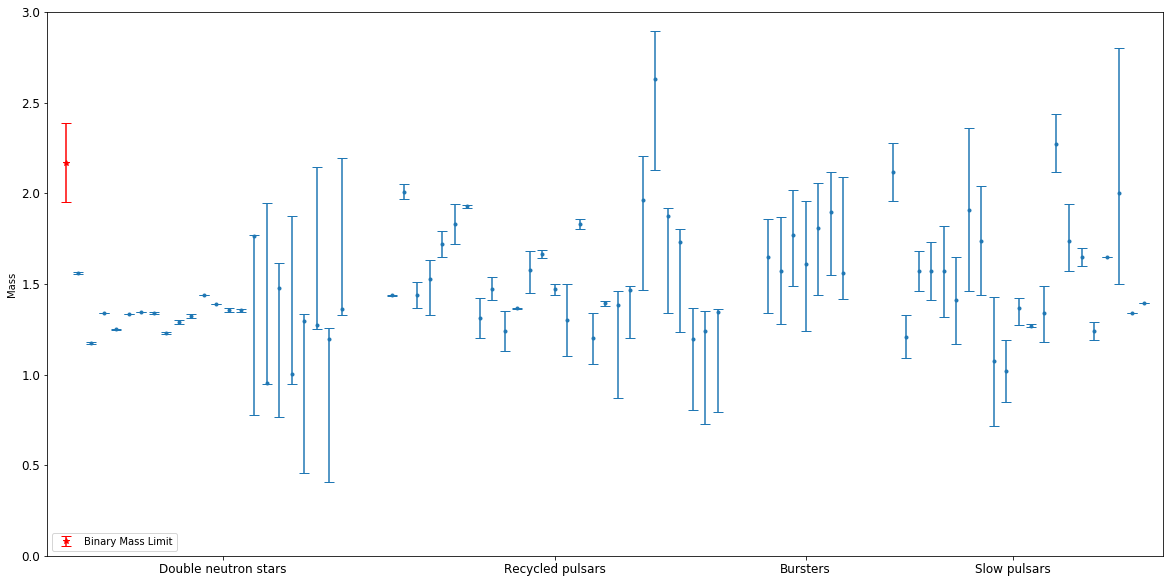

In [6]:
### More data formatting

# Errors
massErrs = np.zeros((2, len(masses)))
massErrs[0] = loErr
massErrs[1] = hiErr

# Plot masses
fig, ax = plt.subplots(figsize=[20, 10])
ax.errorbar(range(len(masses)), masses, yerr=massErrs, capsize=5, fmt='.')
ax.errorbar(-1, 2.17, yerr=0.217, fmt='r*', capsize=5, label="Binary Mass Limit")
for tick in ticks:
    ax.plot([0, 3], [tick, tick], 'k--')
ax.set_ylim([0, 3])
ax.set_xlim([-2.5, len(masses)+.5])
ax.set_xticks(labels)
ax.set_xticklabels(cat_names)
ax.set_ylabel("Mass")
ax.legend(loc="lower left")

#plt.savefig(plot_dir+"mass_distr.png", bbox_inches='tight')

Text(0, 0.5, 'Mass ($M_\\odot$)')

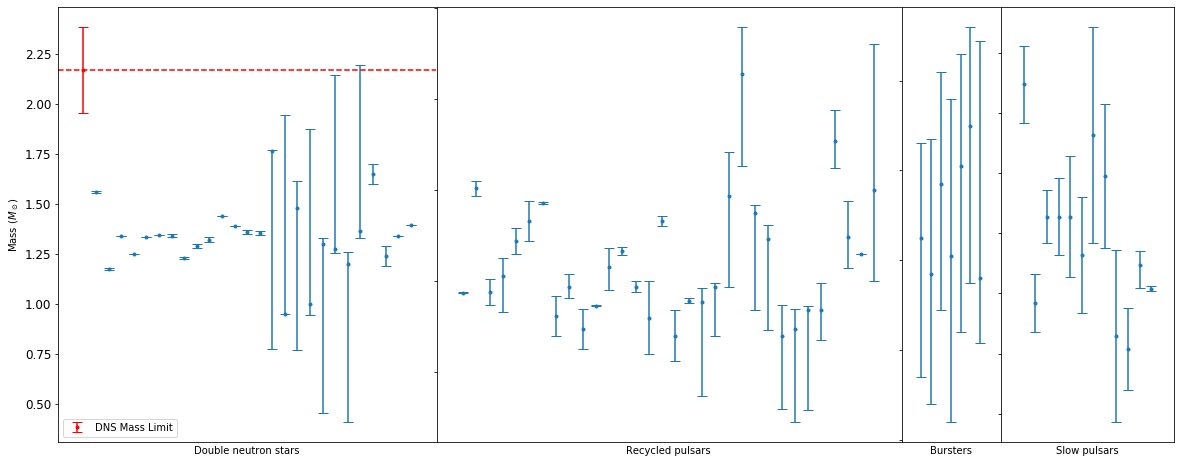

In [7]:
### Another test plot
fig, ax = plt.subplots(figsize=[20, 8])
divider = make_axes_locatable(ax)
slice0 = mass_distr[mass_distr['category']==cats[0]]
#ax2 = divider.new_vertical(size="200%", pad=0.1)
#fig.add_axes(ax2)

#ax3 = divider.new_vertical(size="50%", pad=0.1)
#fig.add_axes(ax3)
axes = []
for i,cat in enumerate(cats):
    # format data
    mass_slice = mass_distr[mass_distr['category']==cat]
    massErrs = np.zeros((2, len(mass_slice)))
    massErrs[0] = mass_slice['minusErr']
    massErrs[1] = mass_slice['plusErr']
    
    if i!=0:
        # find relative size of subplot
        plotstring = str(int(100*len(mass_slice)/len(slice0)))+"%"
        
        # add new subplot
        ax = divider.new_horizontal(size=plotstring, pad=0.01)
        fig.add_axes(ax)
        ax.set_yticklabels([])
        lim = -2
    else:
        lim = -3
        ax.plot([lim, len(mass_slice)+1], [2.17, 2.17], 'r--')
    
    # plot data
    ax.errorbar(range(len(mass_slice)), mass_slice['mass'], yerr=massErrs, capsize=5, fmt='.')
    ax.set_xlim([lim, len(mass_slice)+1])
    
    # format
    ax.set_xlabel(cat_names[i])
    ax.set_xticks([])
    if i!=len(cats)-1:
        ax.spines['right'].set_visible(False)
    
    axes.append(ax)

axes[0].errorbar(-1, 2.17, yerr=.217, color='r', label="DNS Mass Limit", capsize=5, fmt='.')
axes[0].legend(loc="lower left")
axes[0].set_ylabel("Mass ($M_\odot$)")

#plt.savefig(plot_dir+"mass_distr_2.png", bbox_inches='tight')

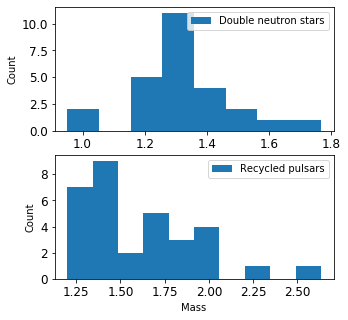

In [8]:
htype = 'bar'
nbins = 10
fig, ax = plt.subplots(len(cats[:2]), 1, figsize=[5, 5])
ranges = mass_distr.plusErr + mass_distr.minusErr
mass_distr['range'] = ranges

for i,cat in enumerate(cats[:2]):
    mass_slice = mass_distr[mass_distr.category==cat]
    nbins = int(len(mass_slice)/3.0)
    n, bins, _ = ax[i].hist(mass_slice.mass, bins=nbins, label=cat_names[i])
    
    ax[i].set_ylabel("Count")
    ax[i].legend()
    
plt.xlabel("Mass")
plt.legend()
plt.savefig(plot_dir+"mass_hist.png", bbox_inches="tight")

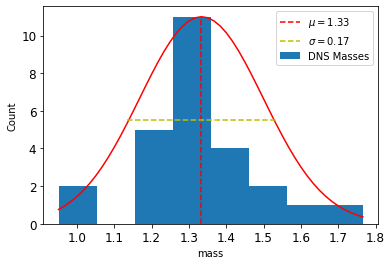

In [9]:
# Get DNS hist data
dn_mass = mass_distr[mass_distr.category==1].mass
n, bins, _ = plt.hist(dn_mass, bins=8, label="DNS Masses")

mu = np.mean(dn_mass)
sig = np.std(dn_mass)

x = np.linspace(min(bins), max(bins), 50)
g_fit = 1/sig * np.exp(-0.5 * ((x-mu)/sig)**2)
g_fit = g_fit/max(g_fit) * max(n)
plt.plot(x, g_fit, 'r')

plt.plot([mu, mu], [0, max(g_fit)], 'r--', label=f"$\mu={mu:.2f}$")
mid = int(len(g_fit)/2)
left_g = g_fit[:mid]
right_g = g_fit[mid:]
fwhm_min = np.argmin(np.abs(left_g-max(g_fit)/2))
fwhm_max = np.argmin(np.abs(right_g-max(g_fit)/2))+mid
plt.plot([x[fwhm_min], x[fwhm_max]], [max(g_fit)/2, max(g_fit)/2], 'y--', label=f"$\sigma={sig:.2f}$")

plt.legend()
plt.xlabel("mass")
plt.ylabel("Count")

plt.savefig(plot_dir+"DNS_fit.png")

In [10]:
### Run pymc3 NUTS sampler with normal distribution as likelihood
# Hyperparameters
a, b, c, d = [1.4, 0.05, 5, 0.01]
si2 = np.maximum(mass_distr.minusErr, mass_distr.plusErr)**2
# pymc3 model
with pm.Model():
    progressbar=False
    # priors
    mu = pm.Normal("mu", mu=a, sigma=b)
    sig2 = pm.InverseGamma("sig2", alpha=c, beta=d)
    
    # Likelihood
    y = pm.Normal("y", mu = mu, sigma = pm.math.sqrt(sig2+si2), observed=mass_distr.mass)
    
    trace = pm.sample(draws=10000, tune=1000, cores=3, progressbar=False)
    
    #_ = pm.traceplot(trace, var_names=["mu", "sig2"])
    
    #pm.summary(trace, var_names=["mu", "sig2"])

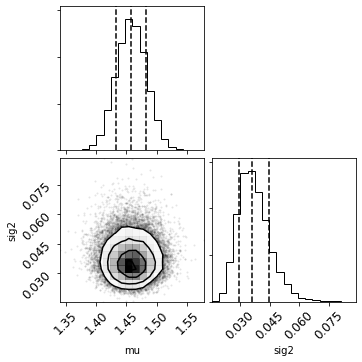

In [11]:
### Plot samples from pymc3
samples = pm.trace_to_dataframe(trace, varnames=["mu", "sig2"])
_ = corner.corner(samples, quantiles=[.16, .50, .84])

In [12]:
def runMCMC(params, mass_distr, sys):
    '''Run pymc3 NUTS sampler with normal distribution as likelihood'''
    # Hyperparameters
    a, b, c, d = params
    # Approximate with Gaussian errors
    si2 = np.maximum(mass_distr.minusErr, mass_distr.plusErr)**2
    
    # pymc3 model
    with pm.Model():
        progressbar=False
        
        # priors
        mu = pm.Normal("mu", mu=a, sigma=b)
        sig2 = pm.InverseGamma("sig2", alpha=c, beta=d)

        # Likelihood
        y = pm.Normal("y", mu = mu, sigma = pm.math.sqrt(sig2+si2), observed=mass_distr.mass)

        trace = pm.sample(draws=sys[0], tune=sys[1], chains=sys[2], cores=sys[3], progressbar=False)
    
    samples = pm.trace_to_dataframe(trace, varnames=["mu", "sig2"])
    return samples

In [13]:
draws = 10000
tune = 1000
chains = 5
cores = 3
system = [draws, tune, chains, cores]

In [17]:
for cat in cats:
    mass_slice = mass_distr[mass_distr.category==cat]
    samples = runMCMC([a,b,c,d], mass_slice, system)
    print(f"Mean: {np.mean(samples.mu)}, $\sigma^2$: {np.mean(samples.sig2)}")

Mean: 1.3572282266993423, $\sigma^2$: 0.007811071346146318
Mean: 1.5039726661531025, $\sigma^2$: 0.04012128836604484
Mean: 1.4390798025994047, $\sigma^2$: 0.00248690003522029
Mean: 1.393651727657118, $\sigma^2$: 0.006543562215673469


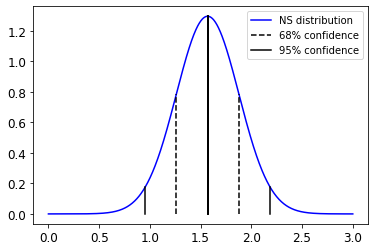

In [15]:
mu = max(samples.mu)
sig2 = max(samples.sig2)
sig = np.sqrt(sig2)
x = np.linspace(0, 3, 1000)
y = 1/np.sqrt(2*np.pi*sig2) * np.exp(-.5*(mu-x)**2/sig2)
plt.plot(x, y, 'b', label="NS distribution")
# Confidence intervals
x_c = [mu-sig, mu+sig, mu-2*sig, mu+2*sig]
y_c = np.interp(x_c, x, y)

for i,x in enumerate(x_c):
    fmt = 'k--' if i<2 else 'k-'
    lbl = None
    if i==0: lbl = "68% confidence"
    if i==2: lbl = "95% confidence"
    plt.plot([x, x], [0, y_c[i]], fmt, label=lbl)
    plt.plot([mu, mu], [0, max(y)], 'k-')
plt.legend()